[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Masao-Taketani/gan_practice/blob/master/dcgan.ipynb)


# The Difference Between WGAN and WGAN-GP
- uses gradient penalty in the critic loss
- does not clip the weights of the critic
- does not use Batch Normalization layers in the critic

In [1]:
from glob import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,\
Activation, Dropout, Flatten, Dense, Reshape, UpSampling2D, LeakyReLU,\
ZeroPadding2D, Layer
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [0]:
# hyper params
num_data = 20579
img_size = 128
channel_size = 3
batch_size = 32

input_dims = (img_size, img_size, channel_size)
num_critic_layers = 4
critic_conv_fils = [32, 64, 128, 256]
critic_conv_kernel_size = [3, 3, 3, 3]
critic_conv_strides = [2, 2, 2, 1]
critic_batch_norm_momentum = 0.8
critic_dropout_rate = 0.25

z_dims = 100
shape_after_dense = (img_size//4, img_size//4, 128)
gen_upsamp_layers = [True, True, False]
gen_batch_norm_momentum = 0.8
gen_dropout_rate = None
num_gen_layers = 3
gen_conv_fils = [128, 64, channel_size]
gen_conv_kernel_size = [3, 3, 3]

In [0]:
img_paths = []

#dataset_path = "dataset/dog_data/"
dataset_path = "drive/My Drive/dataset/gan/dog_imgs/"
img_dirs = glob(dataset_path + "*")
for di in img_dirs:
    imgs = glob(di + "/*")
    for img in imgs:
        img_paths.append(img)
        
len(img_paths)

20590

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!tar -zxvf drive/My\ Drive/datasets/gan/dogs_data/tfrecords/tfrecords_as_one.tar.gz

tfrecords/
tfrecords/whole_dogs_data.tfrecord
tfrecords/.gitkeep


In [0]:
data_path = "tfrecords/whole_dogs_data.tfrecord"

In [0]:
def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([img_size * img_size * channel_size], dtype=tf.float32)
        })
    
    X = features['X']
    
    return X


def iterator(tfrecord_path, num_data):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(num_data)
    iterator = dataset.make_one_shot_iterator()

    X = iterator.get_next()
    X = tf.reshape(X, [-1, img_size, img_size, channel_size])
    
    return X

In [7]:
x_train = iterator(data_path, num_data)
x_train = tf.Session().run(x_train)
x_train.shape



Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(20579, 128, 128, 3)

## Interpolated Images for GP Loss

In [0]:
class RandomWeightedAverageImgs(Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        
    def call(self, inputs, **kwargs):
        alpha = tf.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

## Critic

In [9]:
critic_input = Input(shape=input_dims, name="critic_input")
x = critic_input

for i in range(num_critic_layers):
    x = Conv2D(filters=critic_conv_fils[i],
              kernel_size=critic_conv_kernel_size[i],
              strides=critic_conv_strides[i],
              padding="same",
              name="critic_conv_" + str(i)
              )(x)
    
    if i == 1:
        """
        Arguments:
        padding: Int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
        If int: the same symmetric padding is applied to height and width.
        If tuple of 2 ints: interpreted as two different symmetric padding
            values for height and width: (symmetric_height_pad, symmetric_width_pad).
        If tuple of 2 tuples of 2 ints: interpreted 
            as ((top_pad, bottom_pad), (left_pad, right_pad))
        """
        x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
        
    if critic_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum=critic_batch_norm_momentum)(x)
        
    x = LeakyReLU(alpha=0.2)(x)
    
    if critic_dropout_rate:
        x = Dropout(critic_dropout_rate)(x)
    
x = Flatten()(x)
critic_output = Dense(1, activation=None)(x)
critic_model = Model(critic_input, critic_output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
critic_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 33, 33, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 33, 33, 64)        256   

## Generator

In [0]:
gen_input = Input(shape=(z_dims,), name="gen_input")
x = gen_input
x = Dense(np.prod(shape_after_dense))(x)
x = Activation("relu")(x)
x = Reshape(shape_after_dense)(x)
for i in range(num_gen_layers):
    if gen_upsamp_layers[i]:
        x = UpSampling2D()(x)
        
    x = Conv2D(gen_conv_fils[i],
              gen_conv_kernel_size[i],
              padding="same",
              name="gen_conv_" + str(i)
              )(x)
    
    if i < num_gen_layers - 1:
        if gen_batch_norm_momentum:
            x = BatchNormalization(
            momentum=gen_batch_norm_momentum)(x)
            
        x = Activation("relu")(x)
    else:
        x = Activation("tanh")(x)
        
gen_output = x
gen_model = Model(gen_input, gen_output)

In [12]:
gen_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            13238272  
_________________________________________________________________
activation (Activation)      (None, 131072)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
gen_conv_0 (Conv2D)          (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 128)       512 

## Wasserstein Loss

In [0]:
def wasserstein(y_true, y_pred):
    return K.mean(y_true * y_pred)

# GP Loss  (![CodeCogsEqn](https://user-images.githubusercontent.com/37681936/74709815-710ae200-5263-11ea-9c3d-dd650da0467f.png))

In [0]:
def gradient_penalty(y_true, y_pred, interpolated_samples):
    # gradients(loss, variables)
    # returns the gradients of the loss wrt the variables
    gradients = K.gradients(y_pred, interpolated_samples)[0]
    gradient_l2_norm = K.sqrt(K.sum(
                                K.square(gradients),
                                axis=np.arange(1, len(gradients.shape))
                                   )
                              )
    # squared distance between the l2 nrom and 1
    gradient_penalty = K.square(gradient_l2_norm - 1)
    return K.mean(gradient_penalty)

## Critic Train Model

In [24]:
gen_model.trainable = False
real_imgs = Input(input_dims)
gen_inputs = Input((z_dims,))
fake_imgs = gen_model(gen_inputs)

real_pred = critic_model(real_imgs)
fake_pred = critic_model(fake_imgs)

interpolated_imgs = RandomWeightedAverageImgs(batch_size)(
                      [real_imgs, fake_imgs])
interpolated_pred = critic_model(interpolated_imgs)

gp = partial(gradient_penalty, interpolated_samples=interpolated_imgs)
gp.__name__ = "gradient_penalty"

critic_train_model = Model([real_imgs, gen_inputs],
                     [real_pred, fake_pred, interpolated_pred])
critic_train_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 3)  13462147    input_8[0][0]                    
__________________________________________________________________________________________________
random_weighted_average_imgs_3  (32, 128, 128, 3)    0           input_7[0][0]                    
                                                                 model_1[4][0]              

In [0]:
plot_model(critic_train_model, to_file="model_imgs/wgan-gp_critic_model.png", \
           show_shapes=True)

### Compile the Critic Train Model

In [0]:
critic_train_model.compile(#optimizer=RMSprop(lr=0.00005),
                  optimizer=Adam(0.0002, 0.5),
                  loss=[wasserstein, wasserstein, gp],
                  loss_weights=[1, 1, 10])

## Generator Train Model

In [27]:
critic_model.trainable = False
gen_model.trainable = True

gen_train_inputs = Input((z_dims,))
critic_pred = critic_model(gen_model(gen_train_inputs))
gen_train_model = Model(gen_train_inputs, critic_pred)
gen_train_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Model)              (None, 128, 128, 3)       13462147  
_________________________________________________________________
model (Model)                multiple                  464193    
Total params: 13,926,340
Trainable params: 13,461,763
Non-trainable params: 464,577
_________________________________________________________________


### Compile the Generator Train Model

In [0]:
gen_train_model.compile(optimizer=Adam(0.0002, 0.5),
                        loss=wasserstein)

critic_model.trainable = True

## Train the WGAN-GP

### !!! need to keep implementing from here !!!

In [0]:
def train_critic(critic_train_model, gen_train_model, x_train, batch_size):
    # create 2-dim labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = -np.ones((batch_size, 1))
    # dummy labels for GP
    dummy_labels = np.zeros((batch_size, 1), dtype=np.float32)
    
    # train on real imgs
    # np.random.randint(min, max, size)
    idxes = np.random.randint(0, len(x_train), batch_size)
    real_imgs = x_train[idxes]
    
    # train on fake imgs
    # np.random.normal(mean, std, size)
    # the blow follows the standard normal distribution
    noises = np.random.normal(0, 1, (batch_size, z_dims))
    
    critic_loss = critic_train_model.train_on_batch(
                            [real_imgs, noises],
                            [real_labels, fake_labels, dummy_labels])

    return critic_loss


def train_gen(gen_train_model, batch_size):
    real_labels = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    gen_loss = gen_train_model.train_on_batch(noise, real_labels)
    return gen_loss


def plot_generated_imgs(rows, cols, noises, it, gen_model):
    print("iteration: ", it)

    gen_imgs = gen_model.predict(noises)

    # since gen model outputs values ranging from -1 to 1,
    # nomalize imgs ranging from 0 to 1
    #=====================================================================
    # matplotlib.pyplot.imshow(..., norm=None, ...):
    # By default, a linear scaling mapping the lowest value to 0 and
    # the highest to 1 is used. This parameter is ignored for RGB(A) data.
    #=====================================================================

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(rows, cols)

    ith_img = 0
    for row in range(rows):
        for col in range(cols):
            try:
                axs[row, col].imshow(gen_imgs[ith_img,:,:,:])
                axs[row, col].axis("off")
                ith_img += 1
            except IndexError:
                axs[col].imshow(gen_imgs[ith_img,:,:,:])
                axs[col].axis("off")
                ith_img += 1

[training log]
iteration: 0 critic_ loss: -9.744 (R:3.18, F:-13.86, D:0.09) gen loss: 15.991
iteration:  0
iteration: 1000 critic_ loss: -14.983 (R:46.99, F:-63.52, D:0.15) gen loss: 61.051
iteration:  1000
iteration: 2000 critic_ loss: -1.264 (R:76.23, F:-79.42, D:0.19) gen loss: 76.099
iteration:  2000
iteration: 3000 critic_ loss: -9.650 (R:84.52, F:-94.57, D:0.04) gen loss: 92.475
iteration:  3000
iteration: 4000 critic_ loss: -6.634 (R:87.11, F:-94.02, D:0.03) gen loss: 93.320
iteration:  4000
iteration: 5000 critic_ loss: -14.839 (R:60.32, F:-76.19, D:0.10) gen loss: 70.816
iteration:  5000
iteration: 6000 critic_ loss: -7.586 (R:91.08, F:-100.25, D:0.16) gen loss: 101.930
iteration:  6000
iteration: 7000 critic_ loss: -9.080 (R:41.79, F:-52.47, D:0.16) gen loss: 55.061
iteration:  7000
iteration: 8000 critic_ loss: -15.190 (R:51.87, F:-70.48, D:0.34) gen loss: 68.380
iteration:  8000


KeyboardInterrupt: ignored

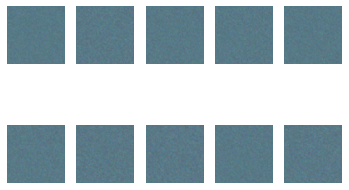

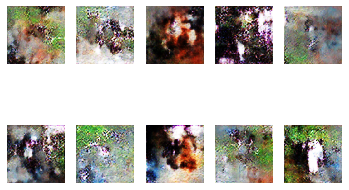

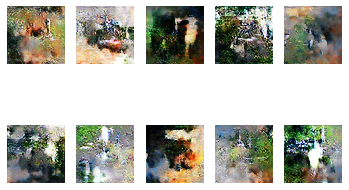

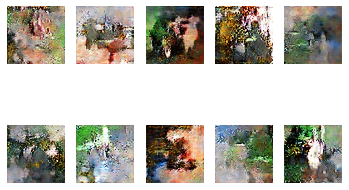

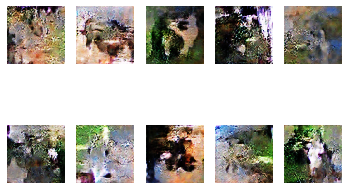

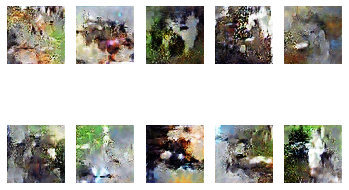

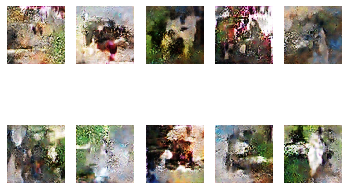

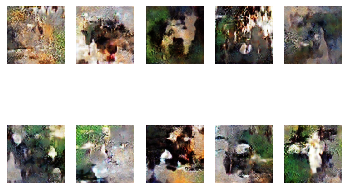

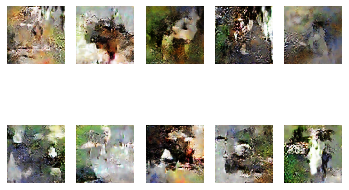

In [34]:
iterations = 20_000
rows, cols = 2, 5
noises = np.random.normal(0, 1, (rows * cols, z_dims))

print("[training log]")
for it in range(iterations):

    for i in range(5):
        if i == 4:
            critic_loss = train_critic(critic_train_model,
                                       gen_train_model,
                                       x_train,
                                       batch_size)
        else:
            _ = train_critic(critic_train_model,
                                       gen_train_model,
                                       x_train,
                                       batch_size)
    
    gen_loss = train_gen(gen_train_model, batch_size)
    
    if it % 1000 == 0:
        print("iteration: %d critic_ loss: %.3f (R:%.2f, F:%.2f, D:%.2f) "
        "gen loss: %.3f" % 
          (it, critic_loss[0], critic_loss[1], critic_loss[2], \
           critic_loss[3], gen_loss))
        plot_generated_imgs(rows, cols, noises, it, gen_model)
        
print("[10 generated images for each 1000th iteration]")